# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [7]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from sklearn.metrics import r2_score

### Preamble

# add ODYM module directory to system path, relative
MainPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Generic_model', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Generic_model', 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Nk = len(IndexTable.Classification[IndexTable.index.get_loc('Capacity')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
Nv = len(IndexTable.Classification[IndexTable.index.get_loc('Make')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)

INFO (<ipython-input-7-52e9f38c30d3> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-7-52e9f38c30d3> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 16. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-7-52e9f38c30d3> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-7-52e9f38c30d3> <<module>

### Preparing stocks

In [10]:
stocks.head()

Year  Passenger vehicles
0  1950               65028
1  1951               69509
2  1952               78643
3  1953               90771
4  1954              108034

In [12]:
### Here we generate the correct format for the data using EUROSTAT as a source for the vehicle fleet data
EUROSTAT = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/docs/Vehicle_files/Pickle_files/Stocks_EUROSTAT_NO.pkl')
stocks = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/IUS_passengerCars_NO_OFV/SSB_Vehicle_Fleet.xlsx', sheet_name='Summary') #TODO: find where this file comes from and put new path with ogical structure in


for j in range(0,Nt):
    for i in range(0,len(EUROSTAT['geo'])):
        if EUROSTAT.index[i] == int(stocks['Year'].iloc[j]):
            stocks['Passenger vehicles'].iloc[j] = EUROSTAT['value'].iloc[i]


IndexError: single positional indexer is out-of-bounds

In [13]:

### This data comes from SSB website for registered vehicels
ssb = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Fleet/SSB_Vehicle_Fleet.xlsx', sheet_name='Summary')
ssb['Country']= 'Norway'
ssb.to_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Stock_driven/Registered_Vehicles_SSB/Vehicle_stocks_SSB.pkl')

In [14]:
ssb.head()

Year  Passenger vehicles Country
0  1950               65028  Norway
1  1951               69509  Norway
2  1952               78643  Norway
3  1953               90771  Norway
4  1954              108034  Norway

Fitting some data somewhat randlomly

In [15]:
def logistic_space(init_value, max_value, half_time, time_start, time_end, rate):
    x = np.zeros(time_end-time_start)
    a = np.linspace(0, time_end-time_start-1,time_end-time_start, dtype=np.int64)
    for i in a: 
        x[i] = init_value + (max_value-init_value)/(1 + math.exp(-rate*(i-(half_time-time_start))))
    return x

In [55]:
fitted = logistic_space(ssb['Passenger vehicles'].iloc[0], ssb['Passenger vehicles'].iloc[-1]*1.1, 1994, 1950, 2050,0.075)

Text(0.5, 0, 'Year')

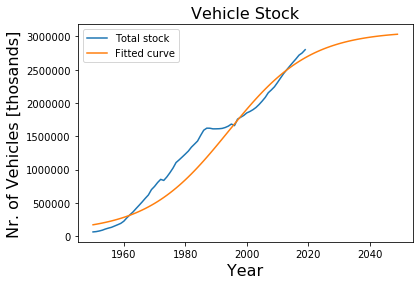

In [56]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(range(1950,2020), 
            ssb['Passenger vehicles'].iloc[::]) 
ax.plot(range(1950,2050), 
            fitted) 
ax.set_ylabel('Nr. of Vehicles [thosands]',fontsize =16)
ax.legend(['Total stock', 'Fitted curve'], loc='best',prop={'size':10})
ax.set_title('Vehicle Stock', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [76]:
# Trying polynomial fit
degree = 4
x = range(1950,2020)
poly = np.poly1d(np.polyfit(x, ssb['Passenger vehicles'].values, degree))

In [77]:
fitted_stock = poly(x)
r_2 = np.corrcoef(poly(x), ssb['Passenger vehicles'].values)[0,1]**2
r_2

0.9966962315672305

Text(0.5, 0, 'Year')

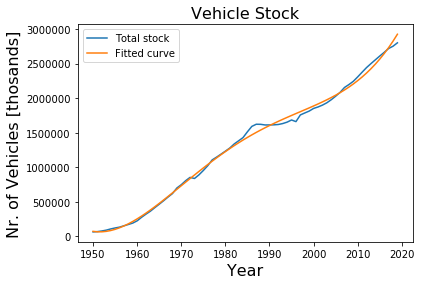

In [78]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(range(1950,2020), 
            ssb['Passenger vehicles'].iloc[::]) 
ax.plot(range(1950,2020), 
            fitted_stock) 
ax.set_ylabel('Nr. of Vehicles [thosands]',fontsize =16)
ax.legend(['Total stock', 'Fitted curve'], loc='best',prop={'size':10})
ax.set_title('Vehicle Stock', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [79]:
# Logistic fit
def logistic(x,ti,tau,C0,C1):
    """
    ti: inflection time
    tau: transition time coefficient
    C0: start value
    C1: end value
    x: vector of observation points (time)
    """

    return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0  

In [91]:
# curve fitting using the logistic function
# it might be necessary to adjust the bounds argument, 
# determining the extreme acceptable value for the parameters of the logistic function.
# Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
xdata = range(1950,2020)
ydata = ssb['Passenger vehicles'].values
popt, pcov = curve_fit(logistic, xdata, ydata, bounds=([min(xdata), 0., 0, max(ydata)], [max(xdata), 2020., min(ydata)*1.5, max(ydata)*1.2]))

print('Logistic regression parameters:', popt)



# as we do not have many data points, we create a linspace to plot the curve
x = np.linspace(min(xdata), max(xdata), max(xdata) - min(xdata))
ppd_smoothed_logistic =  logistic(x, *popt)

Logistic regression parameters: [1.98665633e+03 1.44853508e+01 8.32077072e-20 2.82137434e+06]


Text(0.5, 0, 'Year')

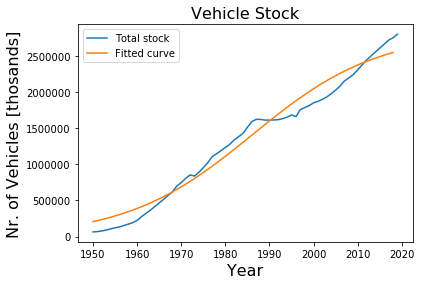

In [92]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(range(1950,2020), 
            ssb['Passenger vehicles'].iloc[::]) 
ax.plot(range(1950,2019), 
            ppd_smoothed_logistic) 
ax.set_ylabel('Nr. of Vehicles [thosands]',fontsize =16)
ax.legend(['Total stock', 'Fitted curve'], loc='best',prop={'size':10})
ax.set_title('Vehicle Stock', fontsize=16)
ax.set_xlabel('Year',fontsize =16)

Merging the two dataframes to create a total stock

In [7]:
a = pd.DataFrame(fitted)

In [8]:
a['Year'] = np.linspace(2020,2050,31)
a['Country'] = 'Norway'

In [9]:
a.rename(columns={0:'Passenger vehicles'}, inplace=True)

In [10]:
total_stock = pd.concat((ssb, a), ignore_index=True)

In [11]:
total_stock.to_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Stock_driven/Registered_Vehicles_SSB/Vehicle_stocks_with_fitted_2050.pkl')

In [12]:
total_stock.head()

Country  Passenger vehicles    Year
0  Norway             65028.0  1950.0
1  Norway             69509.0  1951.0
2  Norway             78643.0  1952.0
3  Norway             90771.0  1953.0
4  Norway            108034.0  1954.0

In [13]:
len(total_stock)

101

In [14]:
StockArray = np.zeros((Nr, Nt))

In [15]:
for m in range(0, len(total_stock)):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index(total_stock['Country'].iloc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(total_stock['Year'].iloc[m])
    StockArray[OriginCountryposition, Timeposition] = total_stock['Passenger vehicles'].iloc[m]

In [16]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Stock_driven/StockArray_ssb_fitted', StockArray, allow_pickle=True)

### Preparing drive trains Inflow Driven

In [17]:
### Preparing battery chemistry data and bringing it to desired structure
DTArray = np.zeros((Nr, Ng, Nt))
drive_trains = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/OFV_TOI_DT/DT_OFV.pkl')

In [18]:
drive_trains['geo'] = 'Norway'

In [19]:
drive_trains = drive_trains.reset_index()

In [20]:
drive_trains['DrivstoffNavn'].unique()

array(['Bensin', 'Bensin Hybrid', 'Bensin Plugin Hybrid', 'Diesel',
       'Diesel Hybrid', 'Diesel Plugin Hybrid', 'Elektrisitet', 'Gass',
       'Hydrogen', 'LNG'], dtype=object)

In [21]:
## SUm all drive trains to fir our own definitions
ice = drive_trains.loc[(drive_trains['DrivstoffNavn'] == 'Diesel') | (drive_trains['DrivstoffNavn'] =='Bensin')].groupby('Aar').sum()
ice['DT'] = 'ICE'
hev = drive_trains.loc[(drive_trains['DrivstoffNavn'] == 'Diesel Hybrid') | (drive_trains['DrivstoffNavn'] =='Bensin Hybrid')].groupby('Aar').sum()
hev['DT'] = 'HEV'
phev = drive_trains.loc[(drive_trains['DrivstoffNavn'] == 'Diesel Plugin Hybrid') | (drive_trains['DrivstoffNavn'] =='Bensin Plugin Hybrid')].groupby('Aar').sum()
phev['DT'] = 'PHEV'
bev = drive_trains.loc[(drive_trains['DrivstoffNavn'] == 'Elektrisitet')].groupby('Aar').sum()
bev['DT'] = 'BEV'
oth = drive_trains.loc[(drive_trains['DrivstoffNavn'] == 'Gass') | (drive_trains['DrivstoffNavn'] =='Hydrogen') | (drive_trains['DrivstoffNavn'] =='LNG')].groupby('Aar').sum()
oth['DT'] = 'OTH'
bev

Antall   DT
Aar                
2002  0.002291  BEV
2003  0.000356  BEV
2004  0.000294  BEV
2005  0.000064  BEV
2006  0.000128  BEV
2007  0.000039  BEV
2008  0.001602  BEV
2009  0.001187  BEV
2010  0.002781  BEV
2011  0.014469  BEV
2012  0.028674  BEV
2013  0.055511  BEV
2014  0.125579  BEV
2015  0.171258  BEV
2016  0.156791  BEV
2017  0.208356  BEV
2018  0.311730  BEV

In [22]:
dt = pd.concat([ice, hev, phev, bev, oth], axis=0)

In [23]:
dt['geo'] = 'Norway'

In [24]:
dt['DT'].unique()

array(['ICE', 'HEV', 'PHEV', 'BEV', 'OTH'], dtype=object)

In [25]:
for m in range(0, len(dt)):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index(dt['geo'].iloc[m])
    DriveTrainPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(dt['DT'].iloc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(dt.index[m])
    DTArray[OriginCountryposition, DriveTrainPosition, Timeposition] = dt['Antall'].iloc[m]

Assigning values for before and after data is available

In [26]:
DTArray[0,0,:52] = 1
DTArray[0,1,:52] = 0
DTArray[0,2,:52] = 0
DTArray[0,3,:52] = 0
DTArray[0,4,:52] = 0

In [27]:
bev_penetration = np.linspace(max(DTArray[0,1,:]), 1,10)
hev_penetration =  np.linspace(max(DTArray[0,3,:]), 0,10)
phev_penetration = np.linspace(max(DTArray[0,4,:]), 0,10)

In [28]:
bev_penetration + hev_penetration+ phev_penetration

array([0.49688218, 0.55278416, 0.60868614, 0.66458812, 0.7204901 ,
       0.77639208, 0.83229406, 0.88819604, 0.94409802, 1.        ])

In [29]:
DTArray[0,1,68:78] = bev_penetration
DTArray[0,0,68:78] = 1- bev_penetration - hev_penetration - phev_penetration
DTArray[0,3,68:78] = hev_penetration
DTArray[0,4,68:78] = phev_penetration

In [30]:
bev_penetration

array([0.31172988, 0.38820434, 0.46467879, 0.54115325, 0.61762771,
       0.69410217, 0.77057663, 0.84705108, 0.92352554, 1.        ])

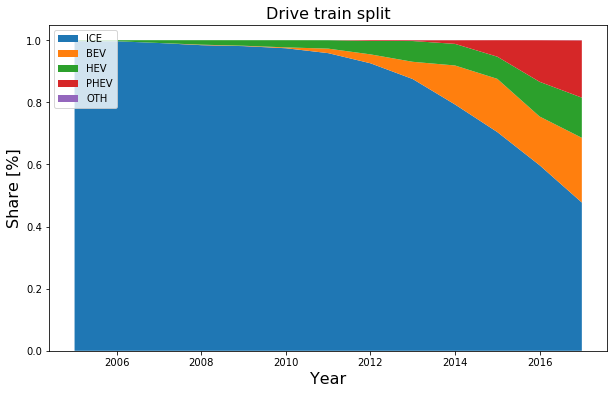

In [31]:
fig, ax = plt.subplots(figsize=(10,6))
ax.stackplot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[55:68], 
            DTArray[0,:,55:68])
ax.set_ylabel('Share [%]',fontsize =16)
ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items, loc='upper left',prop={'size':10})
ax.set_title('Drive train split', fontsize=16)
ax.set_xlabel('Year',fontsize =16)
fig.savefig('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/figures/Inflow_driven_model/Stocks_and_flows/Drive_train_shares')

In [32]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/From OFV_TOI/dt_ofv_toi', DTArray, allow_pickle=True)

In [33]:
#TODO: Add previous and future data. 
#TODO: Remember to name the file differently than above so we can keep an eye on data vs forecasts

### Preparing segment files inflow driven

In [34]:
### Preparing battery chemistry data and bringing it to desired structure
SArray = np.zeros((Nr, Ng, Ns, Nt))
segments = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/OFV_TOI_Segments/OFV_Seg.pkl')

In [35]:
segments['geo'] = 'Norway'

In [36]:
segments = segments.reset_index()

In [37]:
segments.tail()

Aar    DT Weight category    Antall     geo
369  2018  PHEV            a200  0.281408  Norway
370  2018  PHEV            b150  0.014922  Norway
371  2018  PHEV            b160  0.133469  Norway
372  2018  PHEV            b180  0.240335  Norway
373  2018  PHEV            b200  0.329867  Norway

In [38]:
segments['Weight category'].unique()

array(['b100', 'b120', 'b140', 'b130', 'a200', 'b150', 'b160', 'b180',
       'b200'], dtype=object)

In [39]:
for m in range(0, len(segments)):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index(segments['geo'].iloc[m])
    DriveTrainPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(segments['DT'].iloc[m])
    SegmentPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(segments['Weight category'].iloc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(segments['Aar'].iloc[m])
    SArray[OriginCountryposition, DriveTrainPosition, SegmentPosition, Timeposition] = segments['Antall'].iloc[m]

Fill values for before 2002 and after 2018

In [40]:
for g in range(0,Ng):
    for s in range(0,Ns):
        SArray[0,g,s,0:52] = SArray[0,g,s,52]
        SArray[0,g,s,69:] = SArray[0,g,s,68]

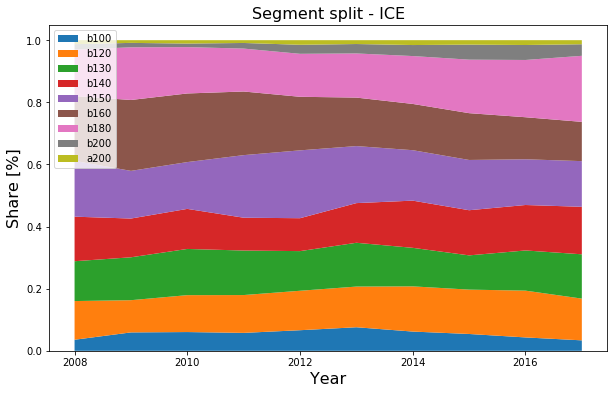

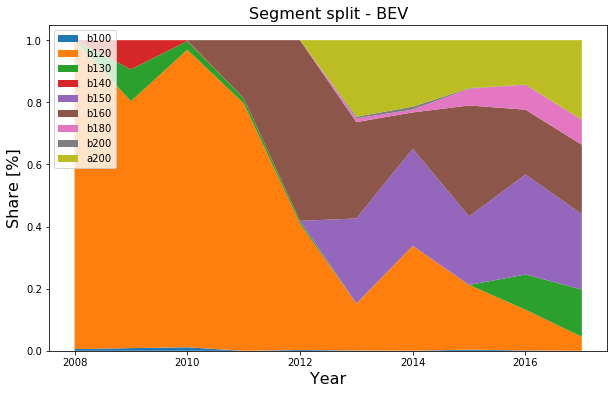

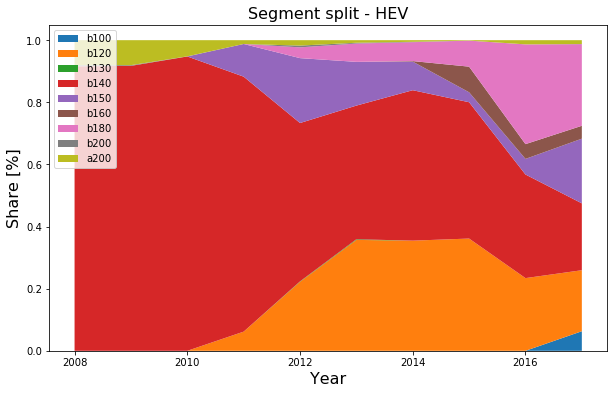

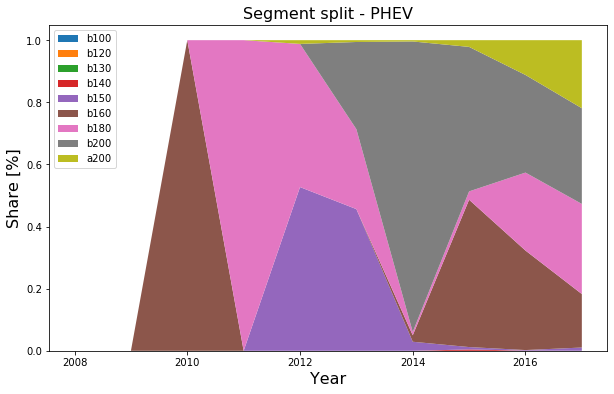

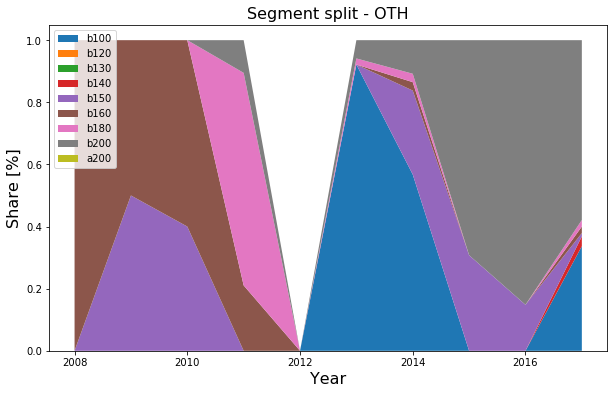

In [41]:
for g in range(0,Ng):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.stackplot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[58:68], 
                SArray[0,g,:,58:68])
    ax.set_ylabel('Share [%]',fontsize =16)
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items, loc='upper left',prop={'size':10})
    ax.set_title('Segment split - {}'.format(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items[g]), fontsize=16)
    ax.set_xlabel('Year',fontsize =16)
    fig.savefig('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/figures/Inflow_driven_model/Stocks_and_flows/Segment_split_{}'.format(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items[g]))

In [42]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/From OFV_TOI/seg_ofv_toi', SArray, allow_pickle= True)

### This section will compare the TOI data with OFV one and create a unified file

In [43]:
toi_ofv = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/From OFV_TOI/Total_sales_ofv_toi.pkl')
ofv = np.load('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/From OFV/Sales_OFV_fitted_2050.npy')

In [44]:
# Bringing pandas dataframe to numpy structured array
toi_ofv_array = np.zeros((Nr, Nt))
for m in range(0, len(toi_ofv)):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(toi_ofv.index[m])
    toi_ofv_array[OriginCountryposition, Timeposition] = toi_ofv['Antall'].iloc[m]

The differneces between the two sources where calculated to be 0.1% and therefore we merge them for the historic data and use the same projections for the future. 

In [45]:
toi_ofv_array[0,0:52] = ofv[0,0:52] # This data includes a projection from 1950 to 1960 and then actual data till 2011
toi_ofv_array[0,69::] = ofv[0,69::] # This is merged purely with the projections we had made in Data_preprocessing.ipynb file

In [46]:
toi_ofv_array

array([[ 41362.89260611,  41374.16239602,  41387.2534921 ,
         41402.45975937,  41420.12231139,  41440.63704891,
         41464.46338114,  41492.13430788,  41524.26806523,
         41561.58156458,  31482.        ,  44327.        ,
         42447.        ,  48048.        ,  55326.        ,
         56319.        ,  60484.        ,  65181.        ,
         65229.        ,  98550.        ,  70226.        ,
         81471.        ,  74680.        ,  88984.        ,
         90293.        , 102811.        , 126997.        ,
        145247.        ,  77821.        ,  88866.        ,
         95550.        , 104670.        , 115573.        ,
        109672.        , 107237.        , 159079.        ,
        167352.        , 115097.        ,  67822.        ,
         54892.        ,  61860.        ,  53382.        ,
         59539.        ,  60822.        ,  85067.        ,
         90502.        , 124994.        , 127733.        ,
        117976.        , 101278.        ,  97378.       

In [47]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Total_sales_combined_and_fitted', toi_ofv_array, allow_pickle=True)

### Preparing capacity per segment and drive train

In [48]:
cap = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/EVDB_OFV_Capacity/Cap_per_seg.pkl')

In [49]:
cap.head()

Year Weight category    DT Manufacturer  Average capacity  \
0  2011            b120   BEV      Peugeot              16.0   
1  2011            b180   BEV       Nissan              24.0   
2  2012            b140  PHEV       Toyota               4.4   
3  2013            a200   BEV        Tesla              85.0   
4  2013            a200  PHEV      Porsche               9.4   

   Weighted average capacity  
0                       16.0  
1                       24.0  
2                        4.4  
3                       85.0  
4                        9.4

In [50]:
CArray_weighted = np.zeros((Nr, Ng, Ns, Nt))
for m in range(0,len(cap['Year'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    DTPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(cap['DT'].loc[m])
    SegPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(cap['Weight category'].loc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(cap['Year'].loc[m])
    CArray_weighted[OriginCountryposition, DTPosition, SegPosition, Timeposition] = cap['Weighted average capacity'].iloc[m]

In [51]:
# Since the capacity is given as "available since", the data goes from the value back to zero when no new models are introduced. Therefore, we re-write those values with the latest weighted average capacity in the market
for g in range(0, Ng):
    for s in range(0, Ns):
        for i in range(0,Nt-1):
            if CArray_weighted[0,g,s,i] != 0 and CArray_weighted[0,g,s,i+1] == 0:
                CArray_weighted[0,g,s,i+1] = CArray_weighted[0,g,s,i]

In [52]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Capacity_per_seg', toi_ofv_array, allow_pickle=True)

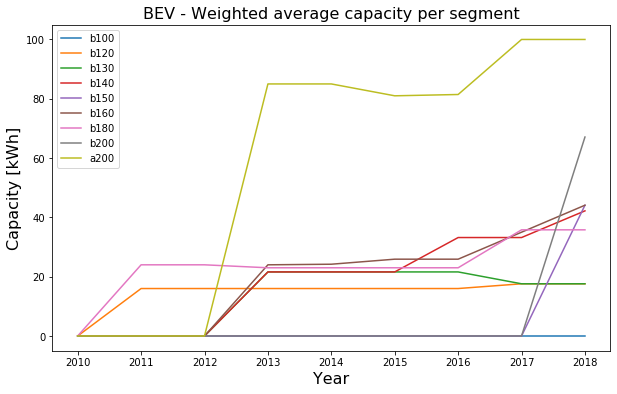

In [53]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[60:69], 
            np.moveaxis(CArray_weighted[0,1,:,60:69], 1, 0))
ax.set_ylabel('Capacity [kWh]',fontsize =16)
ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items, loc='upper left',prop={'size':10})
ax.set_title('BEV - Weighted average capacity per segment', fontsize=16)
ax.set_xlabel('Year',fontsize =16)
fig.savefig('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/figures/Inflow_driven_model/Stocks_and_flows/BEV_average_capacity_per_segment')

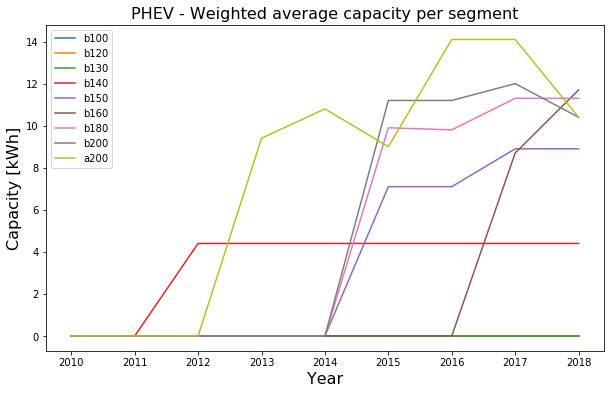

In [54]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[60:69], 
            np.moveaxis(CArray_weighted[0,3,:,60:69], 1, 0))
ax.set_ylabel('Capacity [kWh]',fontsize =16)
ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items, loc='upper left',prop={'size':10})
ax.set_title('PHEV - Weighted average capacity per segment', fontsize=16)
ax.set_xlabel('Year',fontsize =16)
fig.savefig('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/figures/Inflow_driven_model/Stocks_and_flows/PHEV_average_capacity_per_segment')

### Preparing battery chemistry file per segment

In [55]:
### Preparing battery chemistry data and bringing it to desired structure
BCArray = np.zeros((Nr, Ng, Ns, Nb, Nt))
chemistries = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/EVDB_Chemistry/Bat_chem_per_segment.pkl')

In [56]:
chemistries = chemistries.reset_index()

In [57]:
chemistries.head()

Availability_Date_From Weight category   DT battery_type (manually added)  \
0                    2008            b120  BEV                           NMC   
1                    2011            a200  BEV                           NCA   
2                    2011            b120  BEV                       LMO/NMC   
3                    2011            b120  BEV                           NMC   
4                    2011            b140  BEV                           NCA   

     Antall  Battery weight  Curb weight  
0  1.000000             NaN          NaN  
1  1.000000             NaN          NaN  
2  0.439951             1.0          1.0  
3  0.560049             0.0          0.0  
4  1.000000             NaN          NaN

In [58]:
for m in range(0,len(chemistries['Availability_Date_From'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    DTPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(chemistries['DT'].loc[m])
    SegPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(chemistries['Weight category'].loc[m])
    ChemPosition = IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(chemistries['battery_type (manually added)'].loc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(chemistries['Availability_Date_From'].loc[m])
    BCArray[OriginCountryposition, DTPosition, SegPosition, ChemPosition, Timeposition] = chemistries['Antall'].iloc[m]

In [59]:
### When there is no data available, assume constant
# Since the capacity is given as "available since", the data goes from the value back to zero when no new models are introduced. Therefore, we re-write those values with the latest weighted average capacity in the market
for g in range(0, Ng):
    for s in range(0, Ns):
        for b in range(0,Nb):
            for i in range(0,Nt-1):
                if BCArray[0,g,s,b, i] != 0 and BCArray[0,g,s,b, i+1] == 0:
                    BCArray[0,g,s,b, i+1] = BCArray[0,g,s,b, i]

In [60]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Chemistry_per_seg', BCArray, allow_pickle=True)

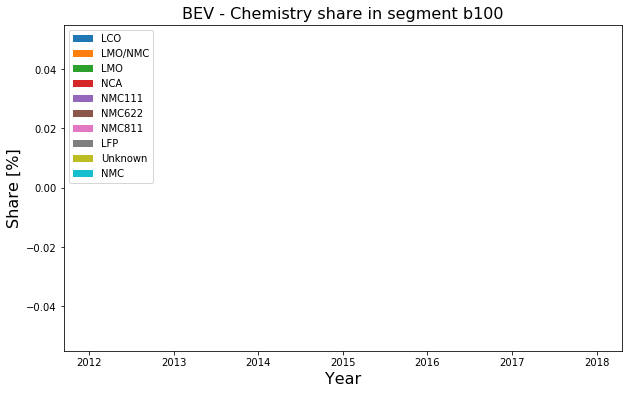

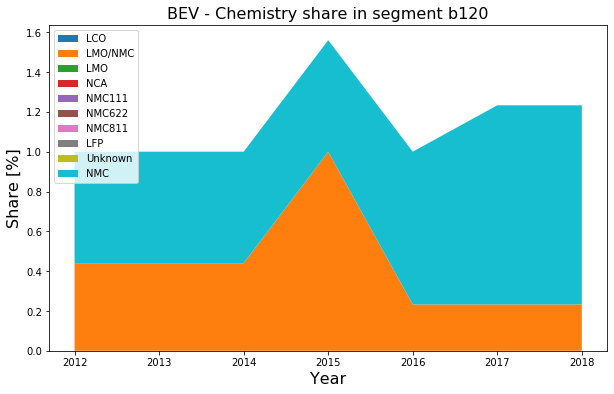

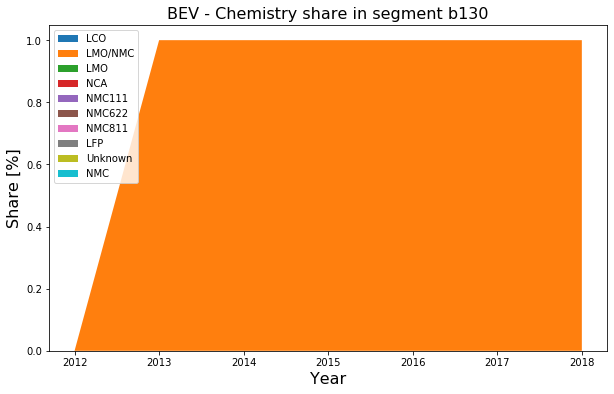

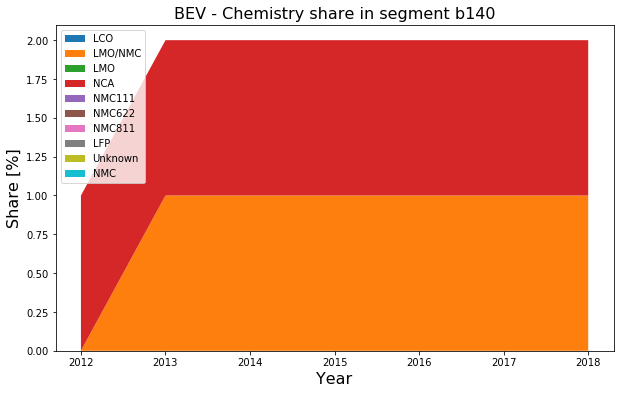

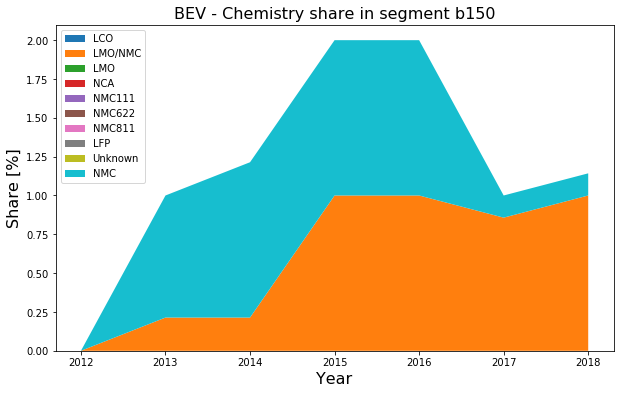

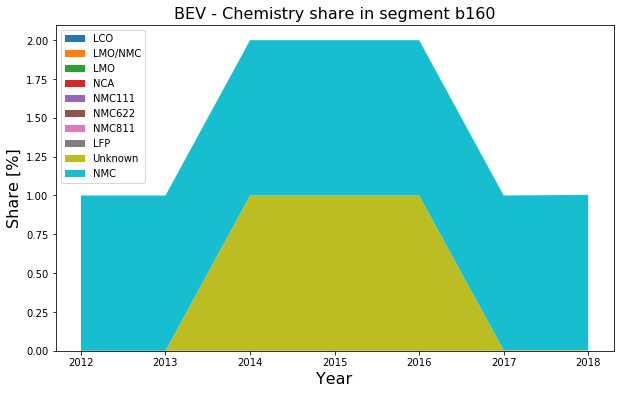

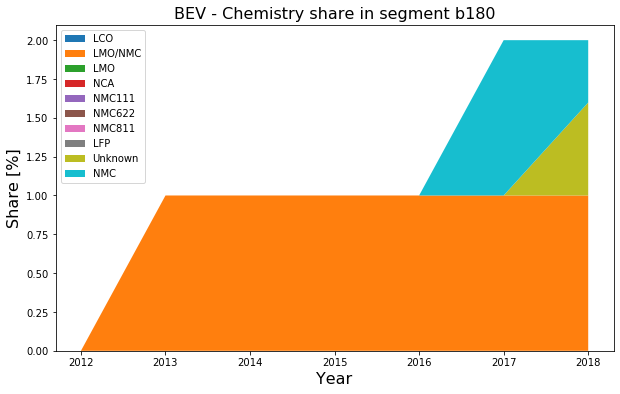

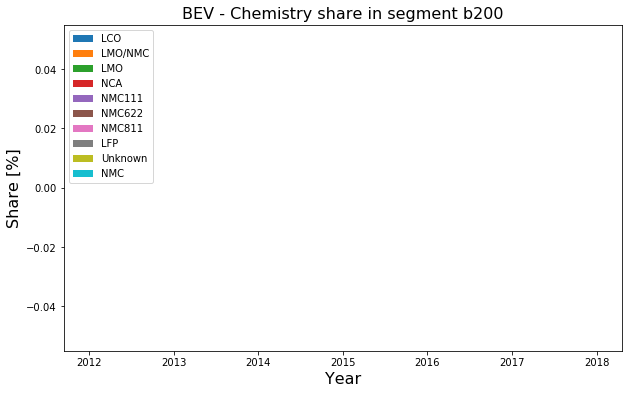

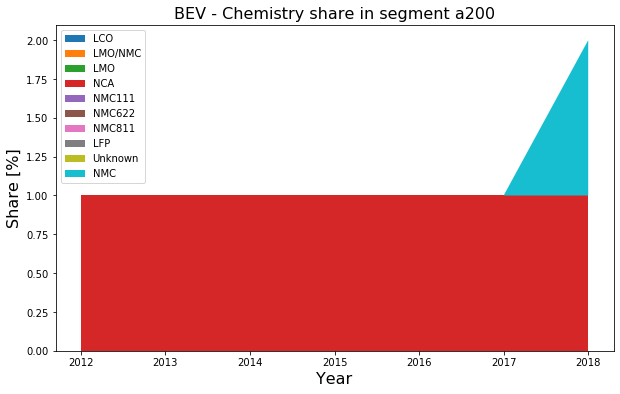

In [61]:
for s in range(0,Ns):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.stackplot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[62:69], 
                BCArray[0,1,s,:,62:69])
    ax.set_ylabel('Share [%]',fontsize =16)
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items, loc='upper left',prop={'size':10})
    ax.set_title('BEV - Chemistry share in segment {}'.format(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items[s]), fontsize=16)
    ax.set_xlabel('Year',fontsize =16)
    fig.savefig('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/figures/Inflow_driven_model/Stocks_and_flows/BEV_chemitry_split_{}'.format(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items[s]))

## Preparing make marketshare

In [62]:
make = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/OFV_TOI_Segments/Make_share_per_dt_seg.pkl')

In [63]:
make = make.reset_index()

In [64]:
make.head()

Year   DT Weight category        Make  Marketshare
0  2002  ICE            a200         BMW     0.505051
1  2002  ICE            a200     Bentley     0.010101
2  2002  ICE            a200   Chevrolet     0.010101
3  2002  ICE            a200    Chrysler     0.101010
4  2002  ICE            a200  Land Rover     0.131313

In [65]:
MakeArray = np.zeros((Nr, Ng, Ns, Nv, Nt))
for m in range(0,len(make['Year'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    DTPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(make['DT'].loc[m])
    SegPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(make['Weight category'].loc[m])
    MakePosition = IndexTable.Classification[IndexTable.index.get_loc('Make')].Items.index(make['Make'].loc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(make['Year'].loc[m])
    MakeArray[OriginCountryposition, DTPosition, SegPosition, MakePosition, Timeposition] = make['Marketshare'].iloc[m]


In [66]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Make_per_seg', MakeArray, allow_pickle=True)

## Preparing chemistry per make and segment

In [67]:
chem = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/OFV_TOI_Segments/Chemistry_share_per_dt_seg_make.pkl')

In [68]:
chem.head()

Year   DT Weight category     Make Chemistry  Marketshare
0  2002  BEV            b100    Kewet   Unknown     0.030303
1  2002  BEV            b100    Think   Unknown     0.969697
2  2002  BEV            b120  Citroën   LMO/NMC     1.000000
3  2002  BEV            b140  Renault   LMO/NMC     1.000000
4  2002  HEV            b130   Toyota   Unknown     1.000000

In [69]:
ChemArray = np.zeros((Nr, Ng, Ns, Nv, Nb, Nt))
for m in range(0,len(chem['Year'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    DTPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(chem['DT'].loc[m])
    SegPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(chem['Weight category'].loc[m])
    MakePosition = IndexTable.Classification[IndexTable.index.get_loc('Make')].Items.index(chem['Make'].loc[m])
    ChemPosition = IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(chem['Chemistry'].loc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(chem['Year'].loc[m])
    ChemArray[OriginCountryposition, DTPosition, SegPosition, MakePosition, ChemPosition, Timeposition] = chem['Marketshare'].iloc[m]

In [70]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Chem_per_make_seg_dt.pkl', ChemArray, allow_pickle=True)

## Preparing battery weight per segment and chemistry

In [71]:
weight = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/OFV_TOI_Segments/Battery_weight_ratio.pkl')

In [72]:
weight = weight.reset_index()

In [73]:
weight.dropna(inplace=True)

In [74]:
vehicles = weight['Weight category'].to_numpy()
vehicle = np.zeros((len(vehicles)))
for i in range(0,len(vehicles)):
    try:
        vehicle[i] = int(vehicles[i][1:])*10
    except: 
        pass
vehicles

array(['b120', 'b150', 'b200', 'b130', 'b180', 'b160', 'b150', 'b180',
       'b130', 'b130', 'b150', 'a200', 'b150', 'b150', 'b160', 'b180',
       'b150', 'b160', 'a200', 'a200', 'b160', 'b200', 'b130'],
      dtype=object)

In [75]:
weight['Vehicle weight'] = vehicle

In [76]:
weight['Battery weight'] = weight['Vehicle weight'] * weight['Ratio']

In [77]:
WeightArray = np.zeros((Nr, Ng, Ns, Nb, Nt))
for m in range(0,len(weight['Year'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    DTPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index('BEV')
    SegPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(weight['Weight category'].iloc[m])
    ChemPosition = IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(weight['Chemistry'].iloc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(weight['Year'].iloc[m])
    WeightArray[OriginCountryposition, DTPosition, SegPosition, ChemPosition, Timeposition] = weight['Battery weight'].iloc[m]

In [78]:
for g in range(0, Ng):
    for s in range(0, Ns):
        for b in range(0,Nb):
            for i in range(0,Nt-1):
                if WeightArray[0,g,s,b, i] != 0 and WeightArray[0,g,s,b, i+1] == 0:
                    WeightArray[0,g,s,b, i+1] = WeightArray[0,g,s,b, i]
                else:
                    WeightArray[0,g,s,b, i] = 260

In [79]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Battery_weight_share', WeightArray, allow_pickle=True)

## Preparing generic battery weight split

In [80]:
PartsArray = np.zeros((Nr, Ng, Nb, Np, Nt))

In [81]:
Np

3

In [82]:
PartsArray[0,1,:,0,:] = 0.7
PartsArray[0,1,:,1,:] = 0.2
PartsArray[0,1,:,2,:] = 0.1

In [83]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Battery_parts_share', PartsArray, allow_pickle=True)

In [84]:
PartsArray.shape

(1, 5, 10, 3, 101)

## Preparing battery materials per kg

In [85]:
First_year=2000
Last_year=2050
### Cells weight
LMO_NMC_Si = logistic_space(0.2, 0.2, 2030, First_year, Last_year, 0.25)
LMO_NMC_Ni = logistic_space(0.2, 0.2, 2030, First_year, Last_year, 0.25)
LMO_NMC_Mn = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.1)
LMO_NMC_Li = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
LMO_NMC_Cu = logistic_space(0.0, 0.1, 2030, First_year, Last_year, 0.25)
LMO_NMC_Co = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
LMO_NMC_C = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
LMO_NMC_Al = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
LMO_NMC_Other = 1 - LMO_NMC_Si - LMO_NMC_Ni - LMO_NMC_Mn - LMO_NMC_Li - LMO_NMC_Cu - LMO_NMC_Co - LMO_NMC_C - LMO_NMC_Al

NMC_Si = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
NMC_Ni = logistic_space(0.2, 0.48, 2030, First_year, Last_year, 0.25) # NMC cathode seems to make up for 60% of total battery weight. Therefore NMC111 has 20 20 20 % parts of those materials, while NCM811 has 48 6 6 correspondingly
NMC_Mn = logistic_space(0.2, 0.06, 2030, First_year, Last_year, 0.1)
NMC_Li = logistic_space(0.07, 0.07, 2030, First_year, Last_year, 0.25)
NMC_Cu = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
NMC_Co = logistic_space(0.2, 0.06, 2030, First_year, Last_year, 0.25)
NMC_C = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
NMC_Al = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
NMC_Other = 1 - NMC_Si - NMC_Ni - NMC_Mn - NMC_Li - NMC_Cu - NMC_Co - NMC_C - NMC_Al

LMO_Si = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
LMO_Ni = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
LMO_Mn = logistic_space(0.58, 0.58, 2030, First_year, Last_year, 0.1)
LMO_Li = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
LMO_Cu = logistic_space(0.0, 0, 2030, First_year, Last_year, 0.25)
LMO_Co = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
LMO_C = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
LMO_Al = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
LMO_Other = 1 - LMO_Si - LMO_Ni - LMO_Mn - LMO_Li - LMO_Cu - LMO_Co - LMO_C - LMO_Al


### FIXME:These numbers are completely made up
NCA_Si = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
NCA_Ni = logistic_space(0.2, 0.48, 2030, First_year, Last_year, 0.25) # NMC cathode seems to make up for 60% of total battery weight. Therefore NMC111 has 20 20 20 % parts of those materials, while NCM811 has 48 6 6 correspondingly
NCA_Mn = logistic_space(0.2, 0.06, 2030, First_year, Last_year, 0.1)
NCA_Li = logistic_space(0.07, 0.07, 2030, First_year, Last_year, 0.25)
NCA_Cu = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
NCA_Co = logistic_space(0.2, 0.06, 2030, First_year, Last_year, 0.25)
NCA_C = logistic_space(0.1, 0.1, 2030, First_year, Last_year, 0.25)
NCA_Al = logistic_space(0, 0, 2030, First_year, Last_year, 0.25)
NCA_Other = 1 - NCA_Si - NCA_Ni - NCA_Mn - NCA_Li - NCA_Cu - NCA_Co - NCA_C - NCA_Al

In [86]:
### BMS weight
Si = 0.2
Cu = 0.7
Other = 0.1

In [87]:
### Creating dataframes with material content for year zero -> assumed to be constant over time
LMO_NMC = pd.DataFrame([LMO_NMC_Si[0], LMO_NMC_Ni[0], LMO_NMC_Mn[0], LMO_NMC_Li[0], LMO_NMC_Cu[0], LMO_NMC_Co[0], LMO_NMC_C[0], LMO_NMC_Al[0], LMO_NMC_Other[0]], index=['Si', 'Ni', 'Mn', 'Li', 'Cu', 'Co', 'C', 'Al', 'Other'], columns=['LMO/NMC'])
NMC = pd.DataFrame([NMC_Si[0], NMC_Ni[0], NMC_Mn[0], NMC_Li[0], NMC_Cu[0], NMC_Co[0], NMC_C[0], NMC_Al[0], NMC_Other[0]], index=['Si', 'Ni', 'Mn', 'Li', 'Cu', 'Co', 'C', 'Al', 'Other'], columns=['NMC'])
NCA = pd.DataFrame([NCA_Si[0], NCA_Ni[0], NCA_Mn[0], NCA_Li[0], NCA_Cu[0], NCA_Co[0], NCA_C[0], NCA_Al[0], NCA_Other[0]], index=['Si', 'Ni', 'Mn', 'Li', 'Cu', 'Co', 'C', 'Al', 'Other'], columns=['NCA'])
LMO = pd.DataFrame([LMO_Si[0], LMO_Ni[0], LMO_Mn[0], LMO_Li[0], LMO_Cu[0], LMO_Co[0], LMO_C[0], LMO_Al[0], LMO_Other[0]], index=['Si', 'Ni', 'Mn', 'Li', 'Cu', 'Co', 'C', 'Al', 'Other'], columns=['LMO'])

In [88]:
cells = pd.concat([LMO_NMC, NMC, NCA, LMO], axis=1)

In [89]:
modules = cells

In [90]:
modules['Part'] = 'Modules'

In [91]:
pack_LMO_NMC = pd.DataFrame([1], index=['Al'], columns=['LMO/NMC'])
pack_LMO = pd.DataFrame([1], index=['Al'], columns=['LMO'])
pack_NMC = pd.DataFrame([1], index=['Al'], columns=['NMC'])
pack_NCA = pd.DataFrame([1], index=['Al'], columns=['NCA'])

In [92]:
pack = pd.concat([pack_LMO_NMC, pack_LMO, pack_NMC, pack_NCA], axis=1)

In [93]:
pack['Part']='Case (pack)'

In [94]:
BMS_LMO_NMC = pd.DataFrame([Si, Cu, Other], index=['Si', 'Cu', 'Other'], columns=['LMO/NMC'])
BMS_LMO = pd.DataFrame([Si, Cu, Other], index=['Si', 'Cu', 'Other'], columns=['LMO'])
BMS_NMC = pd.DataFrame([Si, Cu, Other], index=['Si', 'Cu', 'Other'], columns=['NMC'])
BMS_NCA = pd.DataFrame([Si, Cu, Other], index=['Si', 'Cu', 'Other'], columns=['NCA'])


In [95]:
BMS = pd.concat([BMS_LMO_NMC, BMS_LMO, BMS_NMC, BMS_NCA], axis=1)

In [96]:
BMS['Part'] = 'BMS, wiring, and equipment'

In [97]:
BMS.reset_index(inplace=True)
pack.reset_index(inplace=True)
modules.reset_index(inplace=True)

In [98]:
BMS = BMS.melt(['Part', 'index'])
pack = pack.melt(['Part', 'index'])
modules= modules.melt(['Part', 'index'])

In [99]:
materials =pd.concat([BMS, pack, modules])

In [100]:
materials.head()

Part  index variable  value
0  BMS, wiring, and equipment     Si  LMO/NMC    0.2
1  BMS, wiring, and equipment     Cu  LMO/NMC    0.7
2  BMS, wiring, and equipment  Other  LMO/NMC    0.1
3  BMS, wiring, and equipment     Si      LMO    0.2
4  BMS, wiring, and equipment     Cu      LMO    0.7

In [101]:
MatArray = np.zeros((Nr, Nb, Np, Ne))

In [102]:
for m in range(0,len(materials['Part'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    ChemPosition = IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(materials['variable'].iloc[m])
    PartPosition = IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items.index(materials['Part'].iloc[m])
    MatPosition = IndexTable.Classification[IndexTable.index.get_loc('Element')].Items.index(materials['index'].iloc[m])
    MatArray[OriginCountryposition, ChemPosition, PartPosition, MatPosition] = materials['value'].iloc[m]

In [103]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Material_content', MatArray, allow_pickle=True)

## Preparing battery capacity per chemistry and segment

In [104]:
capacity = pd.read_pickle('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/For preparation/Inflow_driven/EVDB_Chemistry/Capacity_per_chem_seg_dt.pkl')

In [105]:
capacity.head()

Weight category battery_type (manually added)   DT  size_nominal_kWh  Year
0            b120                           NMC  BEV              17.6  2013
1            b120                           NMC  BEV              17.6  2014
2            b120                           NMC  BEV              17.6  2015
3            b120                           NMC  BEV              17.6  2016
4            b120                           NMC  BEV              17.6  2017

In [106]:
CapArray = np.zeros((Nr, Ng, Ns, Nb, Nt))
for m in range(0,len(capacity['Year'])):
    OriginCountryposition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index('Norway')
    DTPosition = IndexTable.Classification[IndexTable.index.get_loc('Good')].Items.index(capacity['DT'].loc[m])
    SegPosition = IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items.index(capacity['Weight category'].loc[m])
    ChemPosition = IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items.index(capacity['battery_type (manually added)'].loc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(capacity['Year'].loc[m])
    CapArray[OriginCountryposition, DTPosition, SegPosition, ChemPosition, Timeposition] = capacity['size_nominal_kWh'].iloc[m]

In [107]:
### When there is no data available, assume constant
# Since the capacity is given as "available since", the data goes from the value back to zero when no new models are introduced. Therefore, we re-write those values with the latest weighted average capacity in the market
for g in range(0, Ng):
    for s in range(0, Ns):
        for b in range(0,Nb):
            for i in range(0,Nt-1):
                if CapArray[0,g,s,b, i] != 0 and CapArray[0,g,s,b, i+1] == 0:
                    CapArray[0,g,s,b, i+1] = CapArray[0,g,s,b, i]

In [108]:
np.save('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/Pickle_files/Prepared files for model/Inflow_driven/Cap_per_chem_seg_dt.pkl', CapArray, allow_pickle=True)

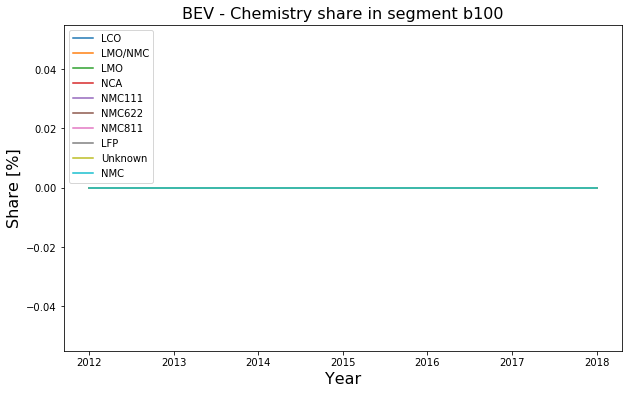

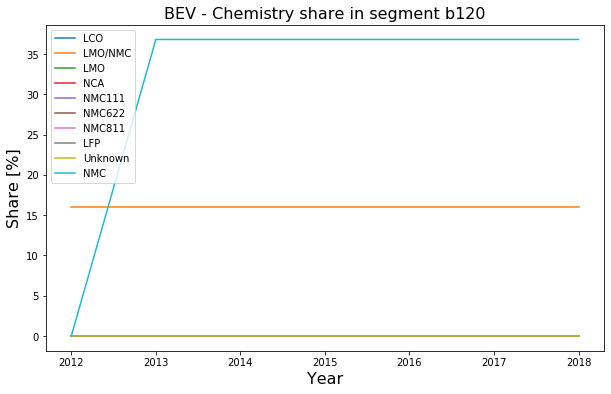

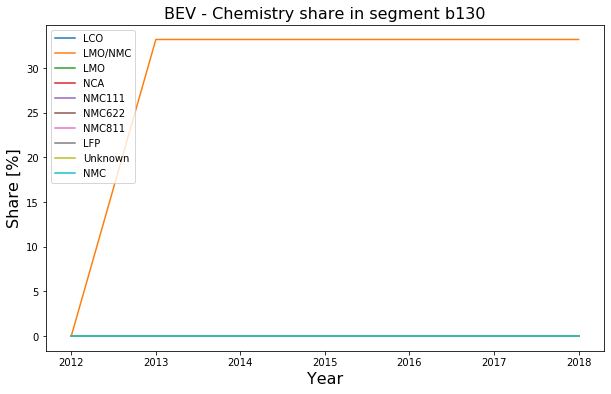

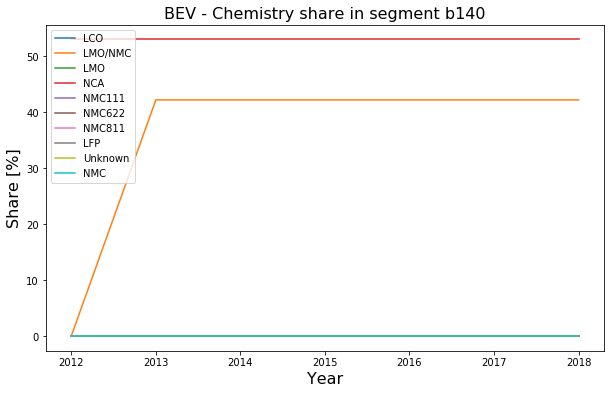

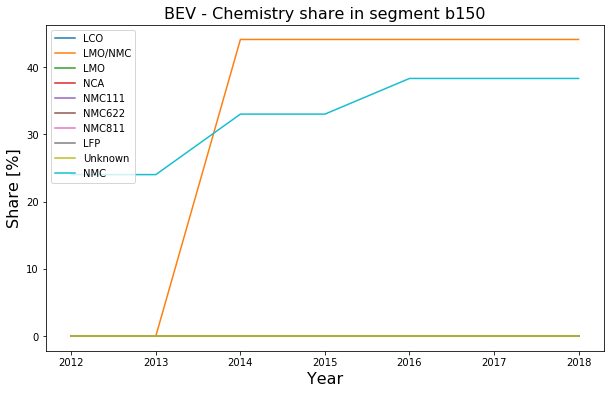

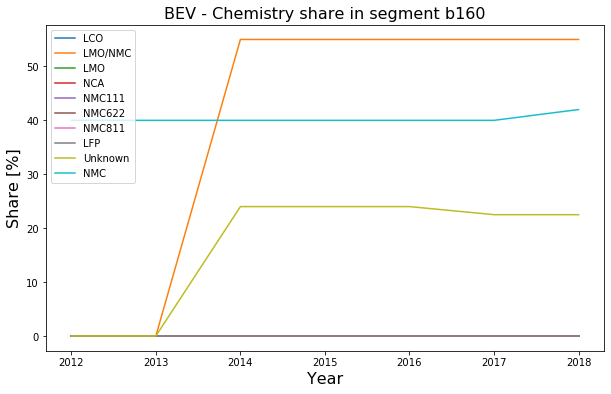

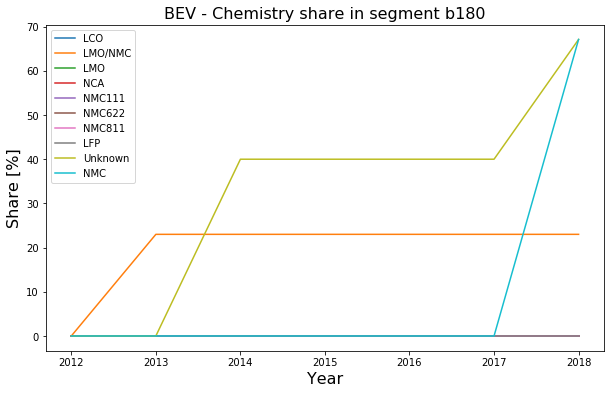

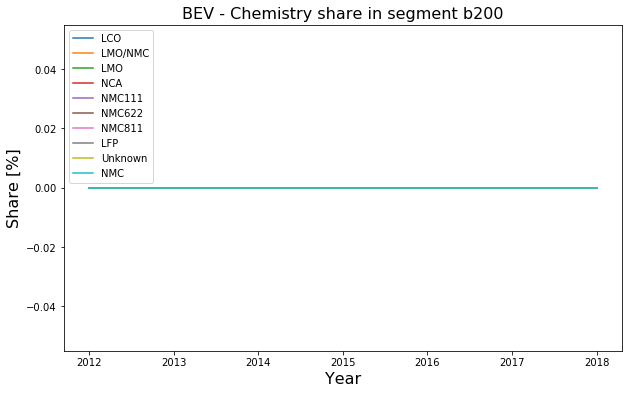

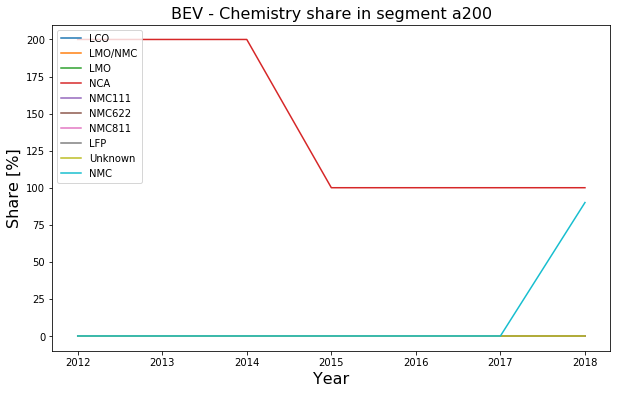

In [109]:
for s in range(0,Ns):
    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items[62:69], 
                np.moveaxis(CapArray[0,1,s,:,62:69], 0,1))
    ax.set_ylabel('Share [%]',fontsize =16)
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items, loc='upper left',prop={'size':10})
    ax.set_title('BEV - Chemistry share in segment {}'.format(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items[s]), fontsize=16)
    ax.set_xlabel('Year',fontsize =16)
    #fig.savefig('/Users/fernaag/Box/BATMAN/Coding/Norwegian_Model/figures/Inflow_driven_model/Stocks_and_flows/BEV_chemitry_split_{}'.format(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items[s]))

### Try to plot 3D thing

indfont: score(<Font '.New York' (NewYork.ttf) normal normal 400 normal>) = 10.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Brush Script MT' (Brush Script.ttf) italic normal 400 normal>) = 11.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Mishafi' (Mishafi.ttf) normal normal regular normal>) = 10.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Georgia' (Georgia Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font '.SF NS Text Condensed' (SFNSTextCondensed-Heavy.otf) normal normal heavy condensed>) = 10.629999999999999
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'STIXGeneral' (STIXGeneralBol.otf) normal normal bold normal>) = 10.335
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'STIXVariants' (STIXVarBol.otf) normal normal bold normal>) = 10.335
DEBUG (font_manager.py <_findfont_cached>): findfont: score(<Font 'Noto S

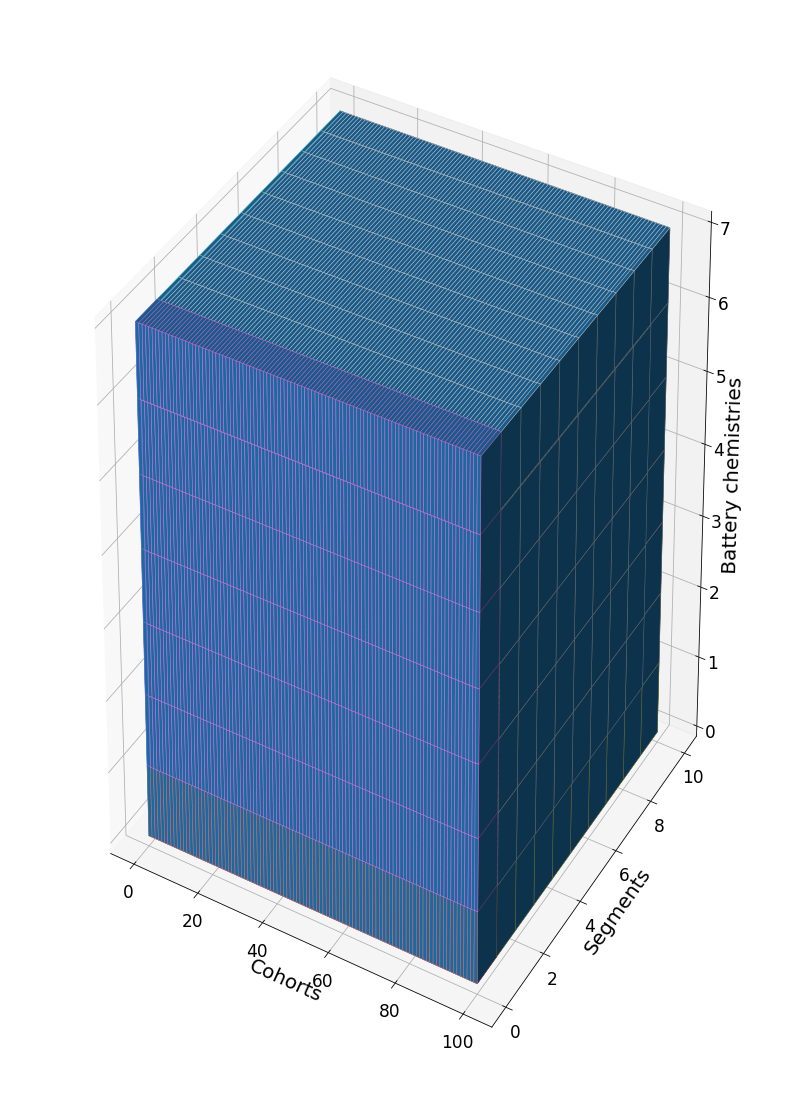

In [145]:
# combine the color components
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

def midpoints(x):
    sl = ()
    for i in range(x.ndim):
        x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
        sl += np.index_exp[:]
    return x

# prepare some coordinates, and attach rgb values to each
r, g, b = np.indices((102, 11, 8))
rc = midpoints(r)
gc = midpoints(g)
bc = midpoints(b)
# prepare some coordinates
x, y, z = np.indices((101, 10, 7))

# draw cuboids in the top left and bottom right corners, and a link between them
cube1 = (x <100) & (y < 10) & (z < 7)

# combine the objects into a single boolean array
voxels = cube1


colors = np.zeros(voxels.shape + (3,))
colors[..., 0] = rc
colors[..., 1] = gc
colors[..., 2] = bc

# and plot everything
fig = plt.figure(figsize=(14,20))
ax = fig.gca(projection='3d')
ax.voxels(r, g, b, voxels,
          edgecolors=np.clip(2*colors - 0.5, 0, 1),  # brighter
          linewidth=0.5)
#ax.set(xlabel='Cohorts', ylabel='Segments', zlabel='Battery Chemistries')
ax.set_ylabel('Segments',fontsize =20)
ax.set_xlabel('Cohorts',fontsize =20)
ax.set_zlabel('Battery chemistries',fontsize =20)
ax.tick_params(axis='both', which='major', labelsize=17)
plt.savefig('/Users/fernaag/Box/BATMAN/Illustrations/Stock_matrix', format='eps')
